In [1]:
pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import os
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


### Transforming text to list of integers, and a list of integers to text
0: " ' " <br>
1: "&nbsp; &nbsp; &nbsp;" <br>
2: " a " <br>
3: " b " <br>
... <br>
26: " y " <br>
27: " z " <br>

In [3]:
class TextTransform:

    """
    Maps characters to integers and vice versa.
    """

    def __init__(self):
        
        self.index_map = {0:"'", 1:" "}
        for ascii_code in range(97, 123):
            self.index_map[ascii_code-95] = chr(ascii_code)
            
        self.char_map = {value:key for key, value in self.index_map.items()}

    def text_to_int(self, text):

        """
        Use a character map and convert text to an integer sequence.
        """

        return [self.char_map[c] for c in text]

    def int_to_text(self, labels):

        """
        Use a label map and convert integer labels to a text sequence.
        """

        return "".join([self.index_map[i] for i in labels])

### Data preprocessing pipeline
Converting signal to corresponding Mel Spectrogram, and labels to list of integers. Data augmentation techniques are added for the signal in training set, using frequency masking and time masking. 

Frequency masking and time masking are methods to augment speech data. They work by cuttingout random blocks of consecutive time and frequency dimension from the spectogram, as suggested 
in the paper [SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition](https://arxiv.org/pdf/1904.08779.pdf).

In [4]:
"""
Object to transform audio for training.
"""

training_audio_transform = nn.Sequential(torchaudio.transforms.MelSpectrogram(sample_rate = 16000, n_mels = 128),
                                         torchaudio.transforms.FrequencyMasking(freq_mask_param = 30),
                                         torchaudio.transforms.TimeMasking(time_mask_param = 100))

"""
Object to transform audio for validation. 
"""

validation_audio_transform = torchaudio.transforms.MelSpectrogram()

"""
Object for text transformation using the class we created above.
"""

text_transform = TextTransform()

### Collate function for the data loaders

Signal is first converted to its Mel spectrogram. The spectrogram is returned in the shape (channel, n_mels, time). We'll need to pad the time dimension to make all the tensors of equal length. We use torch.nn.utils.rnn.pad_sequence function for it. However, for that we need the first dimension of each tensor to be that of time. To get the tensors to be in that shape, we squeeze the channel dimension of the spectrogram, which is 1, and take the transpose between n_mels and time. Now, we can feed the list of tensors in the pad_sequence function. A tensor of shape (batch, time, n_mels) is returned. We unsqueeze the channel dimension, because we need to feed this tensor to a CNN, getting a tensor of shape (batch, channels, time, n_mels) and then we take a transpose between time and n_mels dimensions.

(channel, n_mels, time) $\Rightarrow$ (n_mels, time) $\Rightarrow$ (time, n_mels) $\Rightarrow$ (batch, time, n_mels) $\Rightarrow$ (batch, channel, time, n_mels) $\Rightarrow$ (batch, channel, n_mels, time)

Labels are converted to list of integers using the TextTransform class. The labels are padded to convert the batch into a tensor as well.

In [5]:
def data_processing(data, data_type = "train"):
    
    """
    Collate function for the data loaders. Produces the Mel spectrograms of the signal.
    """

    specs, labels, input_lengths, label_lengths = [], [], [], []
    
    for signal, _, text, _, _, _ in data:
        
        if data_type == "train":
            ms = training_audio_transform(signal).squeeze(0).transpose(0, 1) 
        elif data_type == "validation":
            ms = validation_audio_transform(signal).squeeze(0).transpose(0, 1)
        else:
            raise Exception("data_type parameter should be 'train' or 'validation'")
            
        specs.append(ms)
        input_lengths.append(ms.shape[0] // 2)
        
        label = torch.Tensor(text_transform.text_to_int(text.lower()))
        labels.append(label)
        label_lengths.append(len(label))

    specs = pad_sequence(specs, batch_first = True).unsqueeze(1).transpose(2, 3)
    labels = pad_sequence(labels, batch_first = True)

    return specs, labels, input_lengths, label_lengths

### Model architecture

The first layer in the model is that of a CNN with kernel size 3, and output number of channels equal to n_channels.

A unit of RCNN layers follows the CNN layer. This unit is inspired by the paper [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf). The paper suggests to "view the activation functions (ReLU and BN) as 'pre-activation' of the weight layers, in contrast to conventional wisdom of 'post-activation'." In this model, however, we experiment with layer normalization instead of batch normalization, and with GELU (Gaussian Error Linear Units) instead of ReLU. The paper [Gaussian Error Linear Units (GELUs)](https://arxiv.org/pdf/1606.08415.pdf) reports better performance of the GELU linearity when experimented against ReLU.

The output of the RCNN is then fed into a fully connected layer, with output size equal to rnn_dim.

Then follows the bidirectional GRU unit. Since we need real time transcribing, we use a GRU, instead of an LSTM, because of the lower number of parameters needed to be trained in a GRU. RNNs are known for their ability to capture temporal patterns. The bidirectional nature of the layers ensures that the learning is dependent upon, both, the past and the future elements of the sequence.

Finally, we have the classifier unit, which essentially comprises of two fully connected layers, along with dropout and gelu activation.

In [6]:
class CNNLayerNorm(nn.Module):

    """
    Layer normalization built for CNNs input.
    
    We need a custom class because the normalization needs to be carried out over the second last 
    dimension.
    """

    def __init__(self, n_features):

        super(CNNLayerNorm, self).__init__()
        
        self.layer_norm = nn.LayerNorm(normalized_shape = n_features)

    def forward(self, x):
        
        """
        When passed into CNN, the input is of shape (batch_size, number_of channels, features, time).
        
        We want to normalize each feature, and so, we take a transpose, followed by normalization, 
        followed by another transpose.
        """
        
        x = x.transpose(2, 3).contiguous() 
        x = self.layer_norm(x)
        x = x.transpose(2, 3).contiguous()
        
        return x


class ResidualCNN(nn.Module):
    
    """
    Residual CNN unit, as inspired by the paper 'Identity Mappings in Deep Residual Networks'.
    """
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, dropout_rate, n_features):
        
        super(ResidualCNN, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels = in_channels, 
                              out_channels = out_channels, 
                              kernel_size = kernel_size, 
                              stride = stride, 
                              padding = kernel_size // 2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_channels, 
                              out_channels = out_channels, 
                              kernel_size = kernel_size, 
                              stride = stride, 
                              padding = kernel_size // 2)
        
        self.layer_norm = CNNLayerNorm(n_features = n_features)

        self.gelu = nn.GELU()
        
        self.dropout = nn.Dropout(p = dropout_rate)

    def forward(self, x):
        
        residual = x  
        x = self.dropout(self.gelu(self.layer_norm(x)))
        x = self.cnn1(x)
        x = self.dropout(self.gelu(self.layer_norm(x)))
        x = self.cnn2(x)
        x += residual
        
        return x 


class BidirectionalGRU(nn.Module):
    
    """
    The Bidirectional Gated Recurrent Unit.
    """

    def __init__(self, rnn_dim, hidden_size, dropout_rate, batch_first):
        
        super(BidirectionalGRU, self).__init__()
        
        self.BiGRU = nn.GRU(input_size = rnn_dim, 
                            hidden_size = hidden_size, 
                            batch_first = batch_first, 
                            bidirectional = True)
        
        self.layer_norm = nn.LayerNorm(rnn_dim)

        self.gelu = nn.GELU()
        
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        
        x = self.gelu(self.layer_norm(x))
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        
        return x


class SpeechRecognitionModel(nn.Module):
    
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, num_classes, n_features, n_channels = 32, stride = 2, dropout_rate = 0.1):
        
        super(SpeechRecognitionModel, self).__init__()
        
        n_features = n_features // 2
        
        self.cnn = nn.Conv2d(in_channels = 1, 
                             out_channels = n_channels, 
                             kernel_size = 3, 
                             stride = stride, 
                             padding = 1)  

        self.rcnn_layers = nn.Sequential(*[ResidualCNN(in_channels = n_channels, 
                                                       out_channels = n_channels, 
                                                       kernel_size = 3, 
                                                       stride = 1, 
                                                       dropout_rate = dropout_rate, 
                                                       n_features = n_features) 
                                           for _ in range(n_cnn_layers)])
        
        self.fully_connected = nn.Linear(n_channels*n_features, rnn_dim) 
        
        self.brnn_layers = nn.Sequential(*[BidirectionalGRU(rnn_dim = (rnn_dim if i == 0 else rnn_dim*2),
                                                            hidden_size = rnn_dim, 
                                                            dropout_rate = dropout_rate, 
                                                            batch_first = (i == 0))
                                           for i in range(n_rnn_layers)])
        
        self.classifier = nn.Sequential(nn.Linear(rnn_dim*2, rnn_dim),
                                        nn.GELU(),
                                        nn.Dropout(dropout_rate),
                                        nn.Linear(rnn_dim, num_classes))

    def forward(self, x):
        
        x = self.cnn(x)                                        # (batch, feature, time)
        x = self.rcnn_layers(x)                                # (batch, channels, feature, time)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1]*sizes[2], sizes[3])      # (batch, channels * feature, time)
        x = x.transpose(1, 2)                                  # (batch, time, channels * feature)
        x = self.fully_connected(x)                            # (batch, time, rnn_dim)
        x = self.brnn_layers(x)                                # (batch, time, 2 * rnn_dim)
        x = self.classifier(x)                                 # (batch, time, num_classes)
        
        return x

### Defining metrics for comparing the targets against the predictions

The Levenshtein distance is a string metric for measuring the difference between two sequences. Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other ([source](https://en.wikipedia.org/wiki/Levenshtein_distance#:~:text=Informally%2C%20the%20Levenshtein%20distance%20between,considered%20this%20distance%20in%201965.)).

WER compares reference text and hypothesis text on word level by taking the ratio of the Levenshtein distance between the reference and the hypothesis at word level, and the number of words in the reference.

CER compares reference text and hypothesis text on character level by taking the ratio of the Levenshtein distance between the reference and the hypothesis at character level, and the number of characters in the reference.

In [7]:
def levenshtein_distance(reference, hypothesis):
    
    """
    Method for calculating Levenshtein distance between a pair of lists of elements
    """

    if len(reference) > len(hypothesis):
        reference, hypothesis = hypothesis, reference

    edits = [[None]*(len(reference)+1), list(range(len(reference)+1))]

    for i in range(1, len(hypothesis)+1):
        edits = [edits[1], [0]*(len(reference)+1)]
        edits[1][0] = i
        for j in range(1, len(reference)+1):
            if reference[j-1] != hypothesis[i-1]:
                edits[1][j] = 1 + min(edits[0][j], edits[0][j-1], edits[1][j-1])
            else:
                edits[1][j] = edits[0][j-1]
    
    return edits[1][-1]


def word_errors(reference, hypothesis, ignore_case = False, delimiter = ' '):

    """
    Compute the Levenshtein distance between reference sequence and hypothesis sequence on word level.
    """

    if ignore_case:
        reference, hypothesis = reference.lower(), hypothesis.lower()

    reference_words, hypothesis_words = reference.split(delimiter), hypothesis.split(delimiter)
    lev_distance = levenshtein_distance(reference_words, hypothesis_words)

    return lev_distance, len(reference_words)


def character_errors(reference, hypothesis, ignore_case = False, remove_space = False):

    """
    Compute the Levenshtein distance between reference sequence and hypothesis sequence on character level.
    """

    if ignore_case:
        reference, hypothesis = reference.lower(), hypothesis.lower()
    if remove_space:
        reference, hypothesis = reference.replace(" ", ""), hypothesis.replace(" ", "")

    lev_distance = levenshtein_distance(reference, hypothesis)

    return lev_distance, len(reference)


def word_error_rate(reference, hypothesis, ignore_case = False, delimiter = ' '):

    """
    Calculate word error rate (WER).
    """

    lev_distance, reference_length = word_errors(reference, hypothesis, ignore_case, delimiter)
    if reference_length == 0:
        raise ValueError("Reference should not be an empty string. Hypothesis was " + hypothesis)

    return lev_distance / reference_length


def character_error_rate(reference, hypothesis, ignore_case = False, remove_space = False):

    """
    Calculate charactor error rate (CER).
    """

    lev_distance, reference_length = character_errors(reference, hypothesis, ignore_case, remove_space)
    if reference_length == 0:
        raise ValueError("Reference should not be an empty string. Hypothesis was " + hypothesis)
    
    return lev_distance / reference_length

### Function for decoding the output of the model
The output of the model is in the form of a tensor of integers. This needs to be decoded into text, keeping in mind that repeats need to be ignored. The true labels are sliced to their original length.

In [8]:
def decoder(output, labels, label_lengths, blank_label = 28, collapse_repeated = True):

    # Calculate the character (class) with maximum probabiltiy, (batch, time, n_classes) -> (batch, time)
    arg_maxs = torch.argmax(output, dim = 2)
    
    # Lists of decoded text and target text for all points in a batch
    decoded_targets, decoded_predictions = [], []
    
    for label, label_length, args in zip(labels, label_lengths, arg_maxs):
        
        # Target text sliced to its original length (we padded each label to maximum length)
        decoded_targets.append(text_transform.int_to_text(label[:label_length].tolist()))
        
        # List of integers to be decoded, result of using arg_max
        decoded_int_list = []
        for j in range(len(args)):
            arg_max_0, arg_max_1 = args[j-1] if j != 0 else None, args[j]
            if arg_max_1 != blank_label and (not collapse_repeated or j == 0 or arg_max_0 != arg_max_1):
                decoded_int_list.append(arg_max_1.item())
                
        # Convert the list of integers to text, and the add it to the list of decoded text
        decoded_prediction = text_transform.int_to_text(decoded_int_list)
        decoded_predictions.append(decoded_prediction)
  
    return decoded_targets, decoded_predictions

### Function for training the model

In [9]:
def train(model, device, train_loader, criterion, optimizer, scheduler):
    
    # Put the model in training mode
    model.train()

    # List of train loss
    train_loss = []
    
    for data in tqdm(train_loader):
        
        # Load the data, and convert the tensor with the specified device
        spectrograms, labels, input_lengths, label_lengths = data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        # Forward pass
        output = model(spectrograms)                              # (batch, time, num_classes)
        output = F.log_softmax(output, dim = 2)
        output = output.transpose(0, 1)                           # (time, batch, num_classes)

        # Set the gradients to 0
        optimizer.zero_grad()
        
        # Compute the loss, and with it, the gradients
        loss = criterion(output, labels, input_lengths, label_lengths)
        train_loss.append(loss.item())
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        scheduler.step()

    # Calculate average character error rate and average word error rate
    avg_train_loss = torch.mean(torch.tensor(train_loss))

    print("Training set - Average loss = {:.4f}".format(avg_train_loss))
    time.sleep(2)
    return avg_train_loss

### Function for testing the model

In [10]:
def test(model, device, test_loader, criterion):
    
    # Put the model in testing mode
    model.eval()
    
    # Initialize lists for test loss, character error rate and word error rate
    test_loss, test_cer, test_wer = [], [], []
    
    # Don't compute gradients
    with torch.no_grad():                     
        
        for data in tqdm(test_loader):
            
            # Load the data, and convert the tensor with the specified device
            spectrograms, labels, input_lengths, label_lengths = data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            # Forward pass
            output = model(spectrograms)                              # (batch, time, num_classes)
            output = F.log_softmax(output, dim = 2)
            output = output.transpose(0, 1)                           # (time, batch, num_classes)

            # Compute the loss, and add it to the total
            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss.append(loss.item())

            # Decode targets and predictions
            decoded_targets, decoded_predictions = decoder(output.transpose(0, 1), labels, label_lengths)
            
            # Calculate character error rate and word error rate
            test_cer += [character_error_rate(decoded_target, decoded_prediction) for decoded_target, decoded_prediction in zip(decoded_targets, decoded_predictions)] 
            test_wer += [word_error_rate(decoded_target, decoded_prediction) for decoded_target, decoded_prediction in zip(decoded_targets, decoded_predictions)] 

    # Calculate average character error rate and average word error rate
    avg_test_loss = torch.mean(torch.tensor(test_loss))
    avg_test_cer = torch.mean(torch.tensor(test_cer))
    avg_test_wer = torch.mean(torch.tensor(test_wer))

    print("Validation set - Average loss = {:.4f}, Average CER = {:.4f}, Average WER = {:.4f}".format(avg_test_loss, avg_test_cer, avg_test_wer))
    time.sleep(2)
    return avg_test_loss, avg_test_cer, avg_test_wer

### Bringing it all together

In [11]:
def main(learning_rate = 5e-4, batch_size = 16, epochs = 15, train_url = "train-clean-100", test_url = "test-clean"):

    # Defining hyperparameters
    hparams = {"n_cnn_layers": 3,
               "n_rnn_layers": 5,
               "rnn_dim": 512,
               "num_classes": 29,
               "n_features": 128,
               "stride": 2,
               "dropout_rate": 0.1,
               "learning_rate": learning_rate,
               "batch_size": batch_size,
               "epochs": epochs}

    # If current directory is not data, make one called data
    if not os.path.isdir("./data"):
        os.makedirs("./data")

    # Downloading datasets
    print("Downloading datasets")
    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url = train_url, download = True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url = test_url, download = True)
    
    # kwargs for using GPU
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    print("Using GPU"  if use_cuda else "GPU not found")
    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
    
    # Loading train data
    print("Loading train data")
    train_loader = data.DataLoader(dataset = train_dataset,
                                   batch_size = hparams["batch_size"],
                                   shuffle = True,
                                   collate_fn = lambda x: data_processing(x, "train"),
                                   **kwargs)
    
    # Loading test data
    print("Loading test data")
    test_loader = data.DataLoader(dataset = test_dataset,
                                 batch_size = hparams["batch_size"],
                                 shuffle = False,
                                 collate_fn = lambda x: data_processing(x, "validation"),
                                 **kwargs)

    # Setting up the model
    print("Setting up the model")
    model = SpeechRecognitionModel(n_cnn_layers = hparams["n_cnn_layers"], 
                                   n_rnn_layers = hparams["n_rnn_layers"], 
                                   rnn_dim = hparams["rnn_dim"],
                                   num_classes = hparams["num_classes"], 
                                   n_features = hparams["n_features"], 
                                   stride = hparams["stride"], 
                                   dropout_rate = hparams["dropout_rate"]).to(device)

    print("Total model parameters =", sum([param.nelement() for param in model.parameters()]))

    # Optimizer, loss criterion, and learning rate scheduler
    print("Defining optimizer, loss criterion and learning rate scheduler")
    optimizer = optim.AdamW(model.parameters(), hparams["learning_rate"])
    criterion = nn.CTCLoss(blank = 28).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                              max_lr = hparams["learning_rate"], 
                                              steps_per_epoch = len(train_loader),
                                              epochs = hparams["epochs"],
                                              anneal_strategy = "linear")
    
    # Training the model
    print("\nTraining")
    train_stats = {"Train Losses": []}
    test_stats = {"Test Losses": [], "Test CER": [], "Test WER": []}
    for epoch in range(1, epochs+1):
        print("\nEpoch", epoch)
        time.sleep(2)
        train_loss = train(model, device, train_loader, criterion, optimizer, scheduler)
        test_loss, test_cer, test_wer = test(model, device, test_loader, criterion)
        train_stats["Train Losses"].append(train_loss)
        test_stats["Test Losses"].append(test_loss)
        test_stats["Test CER"].append(test_cer)
        test_stats["Test WER"].append(test_wer)

    return model, train_stats, test_stats

In [12]:
def plot(train_loss, test_loss, xlabel, ylabel, title, labelpad=12, titlepad=12,
         fontdict={"family":"serif", "color":"darkred", "weight":"normal", "size":16}, grid=True):

    plt.figure(figsize=(8, 6))
    plt.xlabel(xlabel, fontdict=fontdict, labelpad=labelpad)
    plt.ylabel(ylabel, fontdict=fontdict, labelpad=labelpad)
    plt.title(title, fontdict=fontdict, pad=titlepad)
    plt.plot(train_loss, color="g", label="Training")
    plt.plot(test_loss, color="b", label="Validation")
    plt.legend()
    if grid:
        plt.grid()
    plt.show()

In [13]:
learning_rate = 5e-4
batch_size = 8
epochs = 15
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

model, train_stats, test_stats = main(learning_rate = learning_rate, 
                                      batch_size = batch_size, 
                                      epochs = epochs, 
                                      train_url = libri_train_set, 
                                      test_url = libri_test_set)

Using GPU
Loading train data
Loading test data
Setting up the model
Total model parameters = 23704989
Defining optimizer, loss criterion and lr scheduler

Training

Epoch 1


100%|██████████| 3568/3568 [27:27<00:00,  2.17it/s]


Training set - Average loss = 2.5082


100%|██████████| 328/328 [02:18<00:00,  2.37it/s]


Validation set - Average loss = 1.5269, Average CER = 0.4957, Average WER = 0.9882

Epoch 2


100%|██████████| 3568/3568 [27:32<00:00,  2.16it/s]


Training set - Average loss = 1.4619


100%|██████████| 328/328 [02:17<00:00,  2.39it/s]


Validation set - Average loss = 1.0712, Average CER = 0.3278, Average WER = 0.8152

Epoch 3


100%|██████████| 3568/3568 [27:30<00:00,  2.16it/s]


Training set - Average loss = 1.1932


100%|██████████| 328/328 [02:20<00:00,  2.33it/s]


Validation set - Average loss = 0.9324, Average CER = 0.2839, Average WER = 0.7445

Epoch 4


100%|██████████| 3568/3568 [27:29<00:00,  2.16it/s]


Training set - Average loss = 1.0515


100%|██████████| 328/328 [02:21<00:00,  2.32it/s]


Validation set - Average loss = 0.8288, Average CER = 0.2688, Average WER = 0.6770

Epoch 5


100%|██████████| 3568/3568 [27:31<00:00,  2.16it/s]


Training set - Average loss = 0.9701


100%|██████████| 328/328 [02:20<00:00,  2.34it/s]


Validation set - Average loss = 0.7408, Average CER = 0.2241, Average WER = 0.6150

Epoch 6


100%|██████████| 3568/3568 [27:31<00:00,  2.16it/s]


Training set - Average loss = 0.8819


100%|██████████| 328/328 [02:22<00:00,  2.30it/s]


Validation set - Average loss = 0.6882, Average CER = 0.2088, Average WER = 0.5856

Epoch 7


100%|██████████| 3568/3568 [27:30<00:00,  2.16it/s]


Training set - Average loss = 0.8117


100%|██████████| 328/328 [02:22<00:00,  2.30it/s]


Validation set - Average loss = 0.6104, Average CER = 0.1835, Average WER = 0.5338

Epoch 8


100%|██████████| 3568/3568 [27:29<00:00,  2.16it/s]


Training set - Average loss = 0.7536


100%|██████████| 328/328 [02:22<00:00,  2.30it/s]


Validation set - Average loss = 0.5820, Average CER = 0.1729, Average WER = 0.5062

Epoch 9


100%|██████████| 3568/3568 [27:33<00:00,  2.16it/s]


Training set - Average loss = 0.7132


100%|██████████| 328/328 [02:22<00:00,  2.31it/s]


Validation set - Average loss = 0.5442, Average CER = 0.1620, Average WER = 0.4825

Epoch 10


100%|██████████| 3568/3568 [27:33<00:00,  2.16it/s]


Training set - Average loss = 0.6610


100%|██████████| 328/328 [02:17<00:00,  2.39it/s]


Validation set - Average loss = 0.5146, Average CER = 0.1502, Average WER = 0.4517

Epoch 11


100%|██████████| 3568/3568 [27:26<00:00,  2.17it/s]


Training set - Average loss = 0.6265


100%|██████████| 328/328 [02:21<00:00,  2.31it/s]


Validation set - Average loss = 0.4982, Average CER = 0.1469, Average WER = 0.4431

Epoch 12


100%|██████████| 3568/3568 [27:30<00:00,  2.16it/s]


Training set - Average loss = 0.5941


100%|██████████| 328/328 [02:25<00:00,  2.26it/s]


Validation set - Average loss = 0.4854, Average CER = 0.1417, Average WER = 0.4279

Epoch 13


100%|██████████| 3568/3568 [27:31<00:00,  2.16it/s]


Training set - Average loss = 0.5633


100%|██████████| 328/328 [02:20<00:00,  2.34it/s]


Validation set - Average loss = 0.4703, Average CER = 0.1352, Average WER = 0.4118

Epoch 14


100%|██████████| 3568/3568 [27:31<00:00,  2.16it/s]


Training set - Average loss = 0.5430


100%|██████████| 328/328 [02:20<00:00,  2.34it/s]


Validation set - Average loss = 0.4588, Average CER = 0.1330, Average WER = 0.4062

Epoch 15


100%|██████████| 3568/3568 [27:31<00:00,  2.16it/s]


Training set - Average loss = 0.5216


100%|██████████| 328/328 [02:20<00:00,  2.33it/s]


Validation set - Average loss = 0.4554, Average CER = 0.1301, Average WER = 0.3981


In [14]:
torch.save(model.state_dict(), "model_state_dict.pt")
torch.save(model, "model.pt")

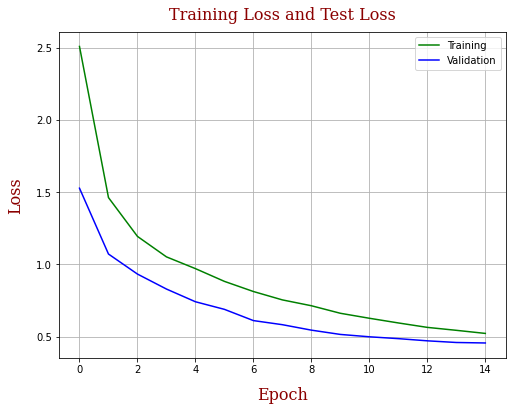

In [15]:
plot(train_loss = train_stats["Train Losses"], 
     test_loss = test_stats["Test Losses"], 
     xlabel = "Epoch", 
     ylabel = "Loss",
     title = "Training Loss and Test Loss")